# 04_GriddedDiagnostics_Frontogenesis_ERA5: Compute derived quantities using MetPy

### In this notebook, we'll compute and plot frontogenesis at a particular isobaric surface.

# <span style="color:purple">0) Imports </span>

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
from datetime import datetime as dt
from metpy.units import units
import metpy.calc as mpcalc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

# <span style="color:purple">1) Specify a starting and ending date/time, regional extent, vertical levels, and access the ERA5</span>

<div class="alert alert-danger">Restrict your date range to no more than 7 days!</div>

In [2]:
# Areal extent
lonW = -90
lonE = -60
latS = 35
latN = 50
cLat, cLon = (latS + latN)/2, (lonW + lonE)/2

# Recall that in ERA5, longitudes run between 0 and 360, not -180 and 180
if (lonW < 0 ):
    lonW = lonW + 360
if (lonE < 0 ):
    lonE = lonE + 360
    
expand = 1
latRange = np.arange(latS - expand,latN + expand,.25) # expand the data range a bit beyond the plot range
lonRange = np.arange((lonW - expand),(lonE + expand),.25) # Need to match longitude values to those of the coordinate variable

# Vertical level specification
pLevel = 700
levStr = f'{pLevel}'

startYear = 2020
startMonth = 12
startDay = 17
startHour = 0
startMinute = 0
startDateTime = dt(startYear,startMonth,startDay, startHour, startMinute)

endYear = 2020
endMonth = 12
endDay = 17
endHour = 18
endMinute = 0
endDateTime = dt(endYear,endMonth,endDay, endHour, endMinute)

delta_time = endDateTime - startDateTime
time_range_max = 7*86400

if (delta_time.total_seconds() > time_range_max):
        raise RuntimeError("Your time range must not exceed 7 days. Go back and try again.")

In [3]:
Wb2EndDate = dt(2023,1,10)
if (endDateTime <= Wb2EndDate):
    ds = xr.open_dataset(
     'gs://weatherbench2/datasets/era5/1959-2023_01_10-wb13-6h-1440x721.zarr', 
     chunks={'time': 48},
     consolidated=True,
     engine='zarr'
)
else: 
    import glob, os
    input_directory = '/free/ktyle/era5'
    files = glob.glob(os.path.join(input_directory,'*.nc'))
    varDict = {'valid_time': 'time', 
               'pressure_level': 'level',
               'msl': 'mean_sea_level_pressure',
               'q': 'specific_humidity',
               't': 'temperature',
               'u': 'u_component_of_wind',
               'v': 'v_component_of_wind',
               'w': 'vertical_velocity',
               'z': 'geopotential'}
    dimDict = {'valid_time': 'time',
               'pressure_level': 'level'}
    ds = xr.open_mfdataset(files).rename_dims(dimDict).rename_vars(varDict)

Examine the `Dataset`

In [4]:
ds

<xarray.Dataset> Size: 47TB
Dimensions:                                           (time: 93544,
                                                       latitude: 721,
                                                       longitude: 1440,
                                                       level: 13)
Coordinates:
  * latitude                                          (latitude) float32 3kB ...
  * level                                             (level) int64 104B 50 ....
  * longitude                                         (longitude) float32 6kB ...
  * time                                              (time) datetime64[ns] 748kB ...
Data variables: (12/50)
    10m_u_component_of_wind                           (time, latitude, longitude) float32 388GB dask.array<chunksize=(48, 721, 1440), meta=np.ndarray>
    10m_v_component_of_wind                           (time, latitude, longitude) float32 388GB dask.array<chunksize=(48, 721, 1440), meta=np.ndarray>
    2m_dewpoint_temperature                           (time, latitude, longitude) float32 388GB dask.array<chunksize=(48, 721, 1440), meta=np.ndarray>
    2m_temperature                                    (time, latitude, longitude) float32 388GB dask.array<chunksize=(48, 721, 1440), meta=np.ndarray>
    angle_of_sub_gridscale_orography                  (latitude, longitude) float32 4MB dask.array<chunksize=(721, 1440), meta=np.ndarray>
    anisotropy_of_sub_gridscale_orography             (latitude, longitude) float32 4MB dask.array<chunksize=(721, 1440), meta=np.ndarray>
    ...                                                ...
    v_component_of_wind                               (time, level, latitude, longitude) float32 5TB dask.array<chunksize=(48, 13, 721, 1440), meta=np.ndarray>
    vertical_velocity                                 (time, level, latitude, longitude) float32 5TB dask.array<chunksize=(48, 13, 721, 1440), meta=np.ndarray>
    volumetric_soil_water_layer_1                     (time, latitude, longitude) float32 388GB dask.array<chunksize=(48, 721, 1440), meta=np.ndarray>
    volumetric_soil_water_layer_2                     (time, latitude, longitude) float32 388GB dask.array<chunksize=(48, 721, 1440), meta=np.ndarray>
    volumetric_soil_water_layer_3                     (time, latitude, longitude) float32 388GB dask.array<chunksize=(48, 721, 1440), meta=np.ndarray>
    volumetric_soil_water_layer_4                     (time, latitude, longitude) float32 388GB dask.array<chunksize=(48, 721, 1440), meta=np.ndarray>

# <span style="color:purple">2) Specify a date/time range, and subset the desired `Dataset`s along their dimensions.</span>

Create a list of date and times based on what we specified for the initial and final times, using Pandas' date_range function

In [5]:
dateList = pd.date_range(startDateTime, endDateTime,freq="6h")
dateList

DatetimeIndex(['2020-12-17 00:00:00', '2020-12-17 06:00:00',
               '2020-12-17 12:00:00', '2020-12-17 18:00:00'],
              dtype='datetime64[ns]', freq='6h')

We will display frontogenesis from the horizontal wind, so pick the relevant variables.

### Now create objects for our desired DataArrays based on the coordinates we have subsetted.

In [6]:
# Data variable selection
U = ds['u_component_of_wind'].sel(time=dateList,level=pLevel,latitude=latRange,longitude=lonRange).compute()
V = ds['v_component_of_wind'].sel(time=dateList,level=pLevel,latitude=latRange,longitude=lonRange).compute()
T = ds['temperature'].sel(time=dateList,level=pLevel,latitude=latRange,longitude=lonRange).compute()

Define our subsetted coordinate arrays of lat and lon. Pull them from any of the DataArrays. We'll need to pass these into the contouring functions later on.

In [7]:
lats = T.latitude
lons = T.longitude

# <span style="color:purple">3) Calculate and visualize 2-dimensional frontogenesis.</span>

#### Unit conversions

In [8]:
UKts = U.metpy.convert_units('kts')
VKts = V.metpy.convert_units('kts')

In [9]:
constrainLat, constrainLon = (0.5, 4.0)
proj_map = ccrs.LambertConformal(central_longitude=cLon, central_latitude=cLat)
proj_data = ccrs.PlateCarree() # Our data is lat-lon; thus its native projection is Plate Carree.
res = '50m'

#### Let's explore the `frontogenesis` diagnostic: https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.frontogenesis.html

#### We first need to compute [potential temperature](https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.potential_temperature.html). First, let's attach units to our chosen pressure level, so that MetPy can calculate potential temperature accordingly.

In [10]:
#Attach units to pLevel for use in MetPy with new variable, P:
P = pLevel*units['hPa']

#### Now calculate potential temperature, and verify that it looks reasonable.

In [11]:
Thta = mpcalc.potential_temperature(P, T)

In [12]:
Thta

<xarray.DataArray (time: 4, latitude: 68, longitude: 128)> Size: 139kB
<Quantity([[[299.3276  299.43286 299.52573 ... 307.984   307.89835 307.71158]
  [298.8612  298.95718 299.049   ... 307.03162 307.05945 307.02954]
  [298.3886  298.48148 298.56195 ... 306.08432 306.14417 306.22156]
  ...
  [285.37256 285.33743 285.3127  ... 283.0508  283.0983  283.2221 ]
  [285.51596 285.4551  285.41382 ... 283.53995 283.55643 283.58533]
  [285.67078 285.59128 285.51392 ... 284.07135 284.1302  284.15802]]

 [[297.10498 297.30515 297.50015 ... 308.08926 308.63306 308.9715 ]
  [296.66125 296.8573  297.08228 ... 307.92828 308.4401  308.67227]
  [296.24954 296.45798 296.6953  ... 307.83334 308.28015 308.41534]
  ...
  [285.33026 285.25388 285.18268 ... 284.33344 284.4645  284.6069 ]
  [285.58203 285.4582  285.34055 ... 284.30972 284.40668 284.514  ]
  [285.80698 285.67282 285.5469  ... 284.287   284.36026 284.4418 ]]

 [[294.7461  294.88126 294.9927  ... 307.03262 307.05222 307.06668]
  [294.17444 294.3385  294.50153 ... 307.03262 307.0739  307.10898]
  [293.7039  293.88757 294.08157 ... 306.99136 307.05945 307.1389 ]
  ...
  [286.32498 286.1537  285.9545  ... 285.07947 285.25906 285.44272]
  [286.22797 286.10104 285.9401  ... 284.869   284.97632 285.09702]
  [286.1764  286.09897 285.97928 ... 284.21994 284.26846 284.32724]]

 [[293.18484 293.14978 293.13327 ... 306.99237 306.96042 306.90057]
  [292.68134 292.63797 292.62042 ... 307.11517 307.08112 307.00168]
  [292.27887 292.23242 292.19632 ... 307.20596 307.1513  307.05945]
  ...
  [288.1297  288.10083 288.0224  ... 283.88974 283.90317 283.9114 ]
  [287.95636 287.95947 287.95117 ... 283.6194  283.65652 283.70297]
  [287.86145 287.82944 287.81085 ... 283.63693 283.6937  283.77213]]], 'kelvin')>
Coordinates:
  * latitude   (latitude) float32 272B 34.0 34.25 34.5 ... 50.25 50.5 50.75
    level      int64 8B 700
  * longitude  (longitude) float32 512B 269.0 269.2 269.5 ... 300.2 300.5 300.8
  * time       (time) datetime64[ns] 32B 2020-12-17 ... 2020-12-17T18:00:00

#### Now calculate frontogenesis, and examine the output `DataArray`.

In [13]:
frnt = mpcalc.frontogenesis(Thta, U, V)
frnt

<xarray.DataArray (time: 4, latitude: 68, longitude: 128)> Size: 279kB
<Quantity([[[ 2.03471677e-10  2.40082198e-10  2.99488522e-10 ... -2.82723865e-10
   -9.63688731e-11 -1.49690502e-10]
  [ 2.07617677e-10  2.26375001e-10  2.71214597e-10 ... -4.53643074e-10
   -2.03073675e-10 -8.42319184e-11]
  [ 1.62739025e-10  1.89518933e-10  2.17813054e-10 ... -4.99334756e-10
   -3.05752936e-10 -5.25233942e-11]
  ...
  [ 5.84595031e-11  5.15224440e-11  5.29578573e-11 ... -8.93054668e-10
   -7.25807006e-10 -5.24956928e-10]
  [ 9.12990065e-11  5.55884110e-11  3.77139886e-11 ... -7.04751511e-10
   -6.43605829e-10 -4.35266359e-10]
  [ 1.52041876e-10  1.03429900e-10  5.21321836e-11 ...  4.18864059e-10
    4.68125586e-10  1.86262845e-10]]

 [[ 1.32920776e-10  1.12988859e-10  1.28672500e-10 ...  1.29210597e-09
    9.46084420e-10  4.20178880e-10]
  [ 1.66898366e-10  1.11648327e-10  1.01673137e-10 ...  1.58441965e-09
    9.84056618e-10  1.77494748e-11]
  [ 1.59458348e-10  1.02326160e-10  8.30333487e-11 ...  1.69113765e-09
    8.42440997e-10 -2.67130550e-10]
...
  [-2.46785842e-10 -2.72907005e-10 -2.58718435e-10 ...  9.04467920e-11
    1.08918929e-11 -3.50670597e-11]
  [-1.67053172e-10 -2.31223050e-10 -2.88840181e-10 ...  1.22174041e-09
    1.47039147e-09  1.73575904e-09]
  [-7.41316905e-11 -4.08157422e-11 -5.37796842e-11 ...  3.53375219e-09
    3.46336230e-09  3.47050698e-09]]

 [[-2.16954487e-10 -2.51583503e-10 -2.92298889e-10 ... -2.83651043e-12
   -4.52724345e-11 -2.85337069e-11]
  [-9.32775066e-11 -1.16804145e-10 -1.31072020e-10 ... -1.20527297e-11
   -9.96860563e-12  6.97212226e-11]
  [-1.70178934e-11 -3.39378613e-11 -3.28962542e-11 ...  7.30724344e-12
    7.96352991e-11  1.40243471e-10]
  ...
  [-1.45859862e-11 -1.00367281e-10 -4.20521349e-11 ... -3.98338098e-10
   -4.01186594e-10 -3.96665114e-10]
  [-6.12575333e-11 -6.03376503e-11 -1.40925078e-10 ... -2.48041895e-10
   -1.98340008e-10 -1.39369882e-10]
  [-1.08934388e-10 -1.92790713e-10 -2.30203984e-10 ... -2.83881438e-10
   -2.07033851e-10 -1.48423681e-10]]], 'kelvin / meter / second')>
Coordinates:
  * latitude   (latitude) float32 272B 34.0 34.25 34.5 ... 50.25 50.5 50.75
    level      int64 8B 700
  * longitude  (longitude) float32 512B 269.0 269.2 269.5 ... 300.2 300.5 300.8
  * time       (time) datetime64[ns] 32B 2020-12-17 ... 2020-12-17T18:00:00

Let's get a quick visualization, using Xarray's built-in interface to Matplotlib.  <i> <b> Note: We need to select a specific time (in this case, the first, or time=0) in order for Matplotlib to be able to make this two-dimensional plot.

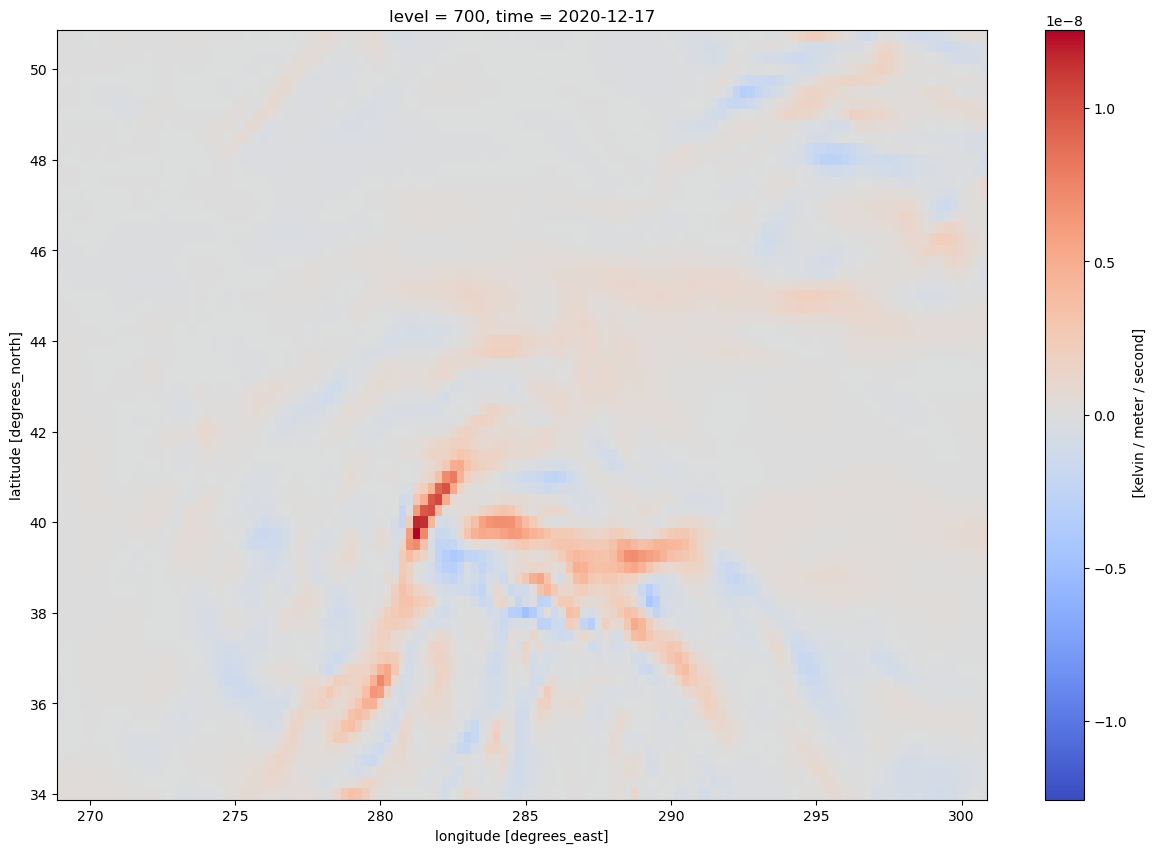

In [14]:
frnt.isel(time=0).plot(figsize=(15,10),cmap='coolwarm')

The units are in degrees K (or C) per meter per second. Traditionally, we plot frontogenesis on more of a meso- or synoptic scale ... K or degrees C per 100 km per 3 hours. Let's simply multiply by the conversion factor.

In [15]:
# A conversion factor to get frontogensis units of K per 100 km per 3 h
convert_to_per_100km_3h = 1000*100*3600*3
frnt = frnt * convert_to_per_100km_3h

Check the range and scale of values.

In [16]:
frnt.min().values, frnt.max().values

(array(-13.41356471), array(32.8404452))

A scale of 1 (i.e., 1x10^0, AKA 1e0) looks appropriate.

In [17]:
scale = 1e0

### Usually, we wish to avoid plotting the "zero" contour line for diagnostic quantities such as divergence, advection, and frontogenesis. Thus, create two lists of values ... one for negative and one for positive.

In [18]:
frntInc = 3
negFrntContours = np.arange (-18, 0, frntInc)
posFrntContours = np.arange (3, 30, frntInc)

### Now, let's plot frontogenesis on the map. 

Processing 2020-12-17 00:00:00
Processing 2020-12-17 06:00:00
Processing 2020-12-17 12:00:00
Processing 2020-12-17 18:00:00


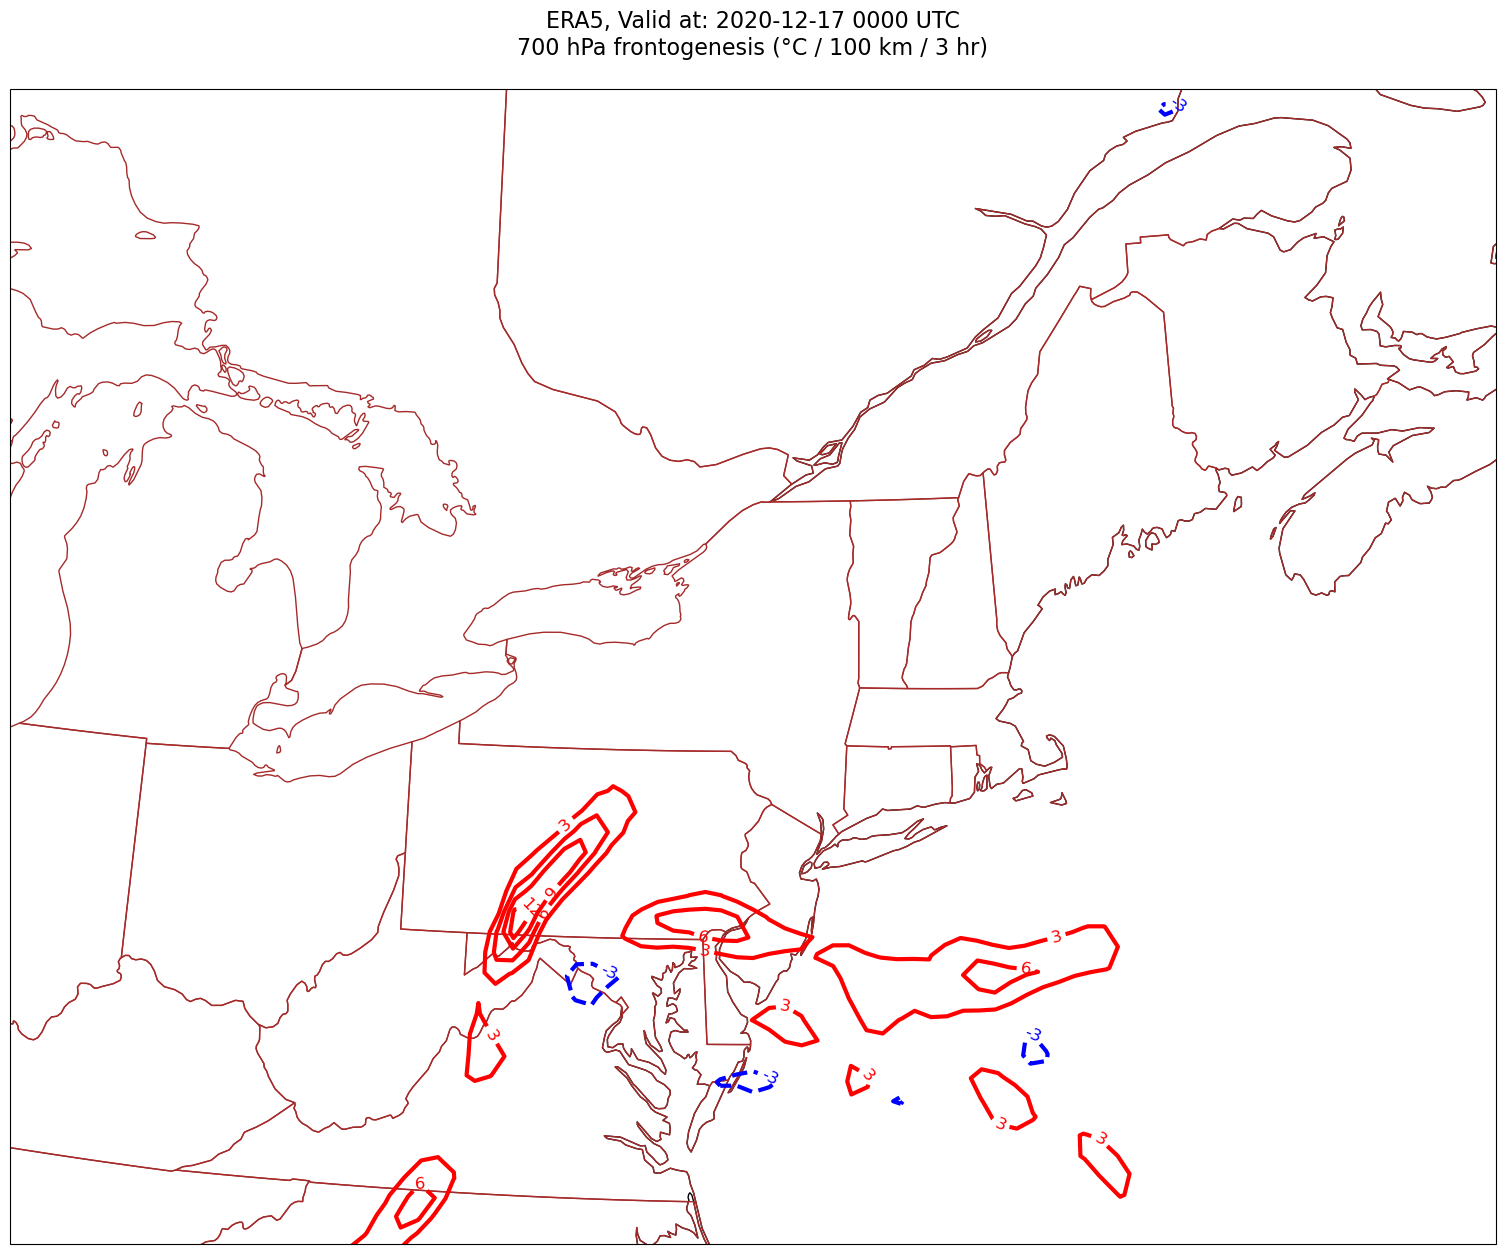

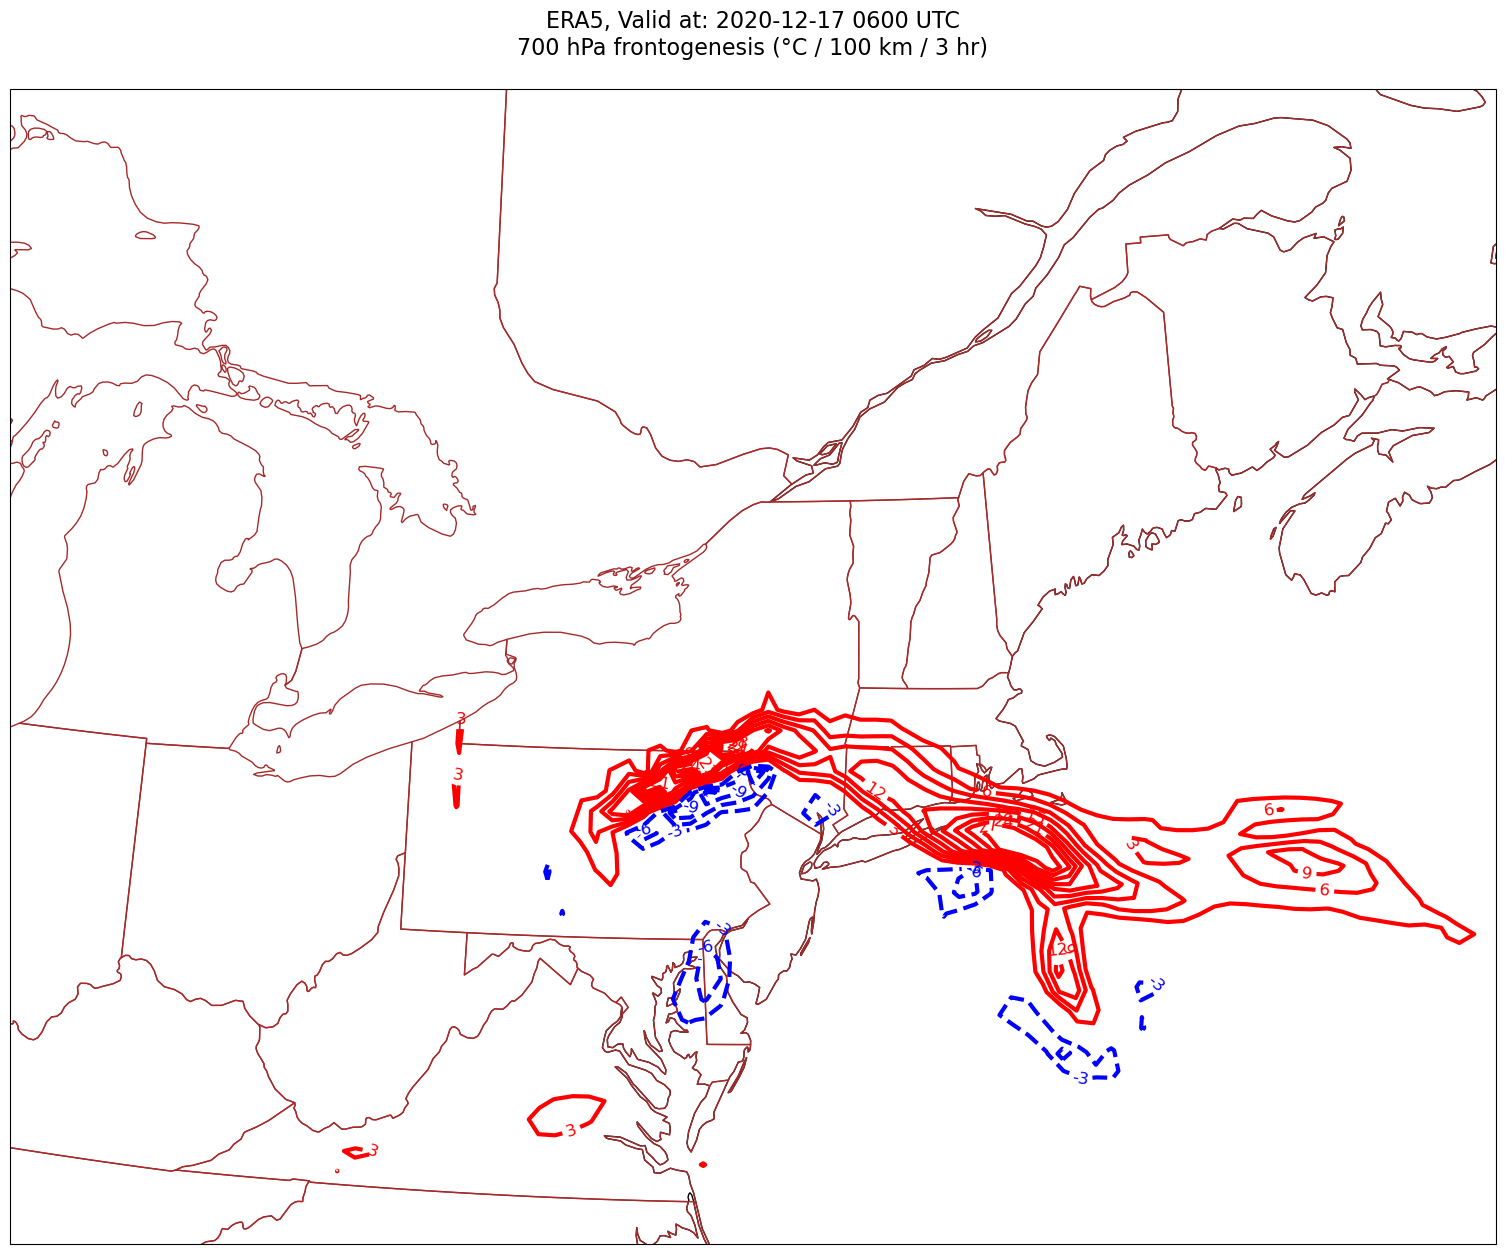

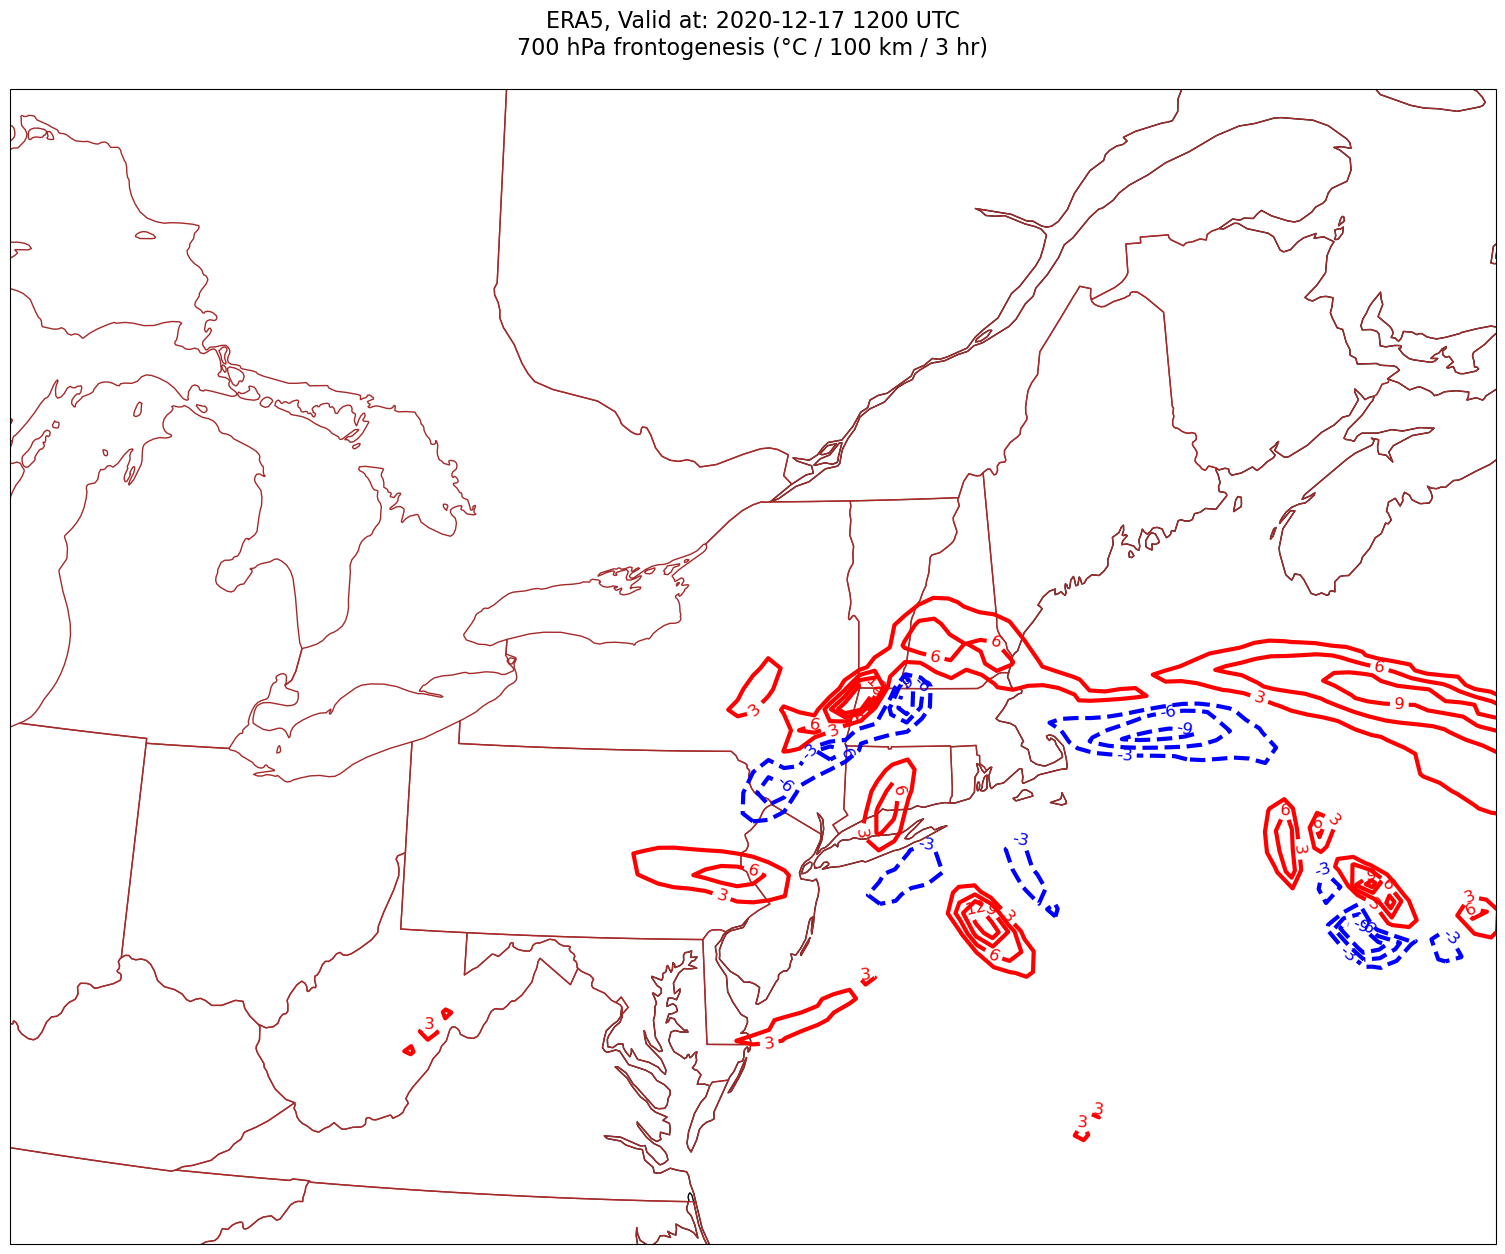

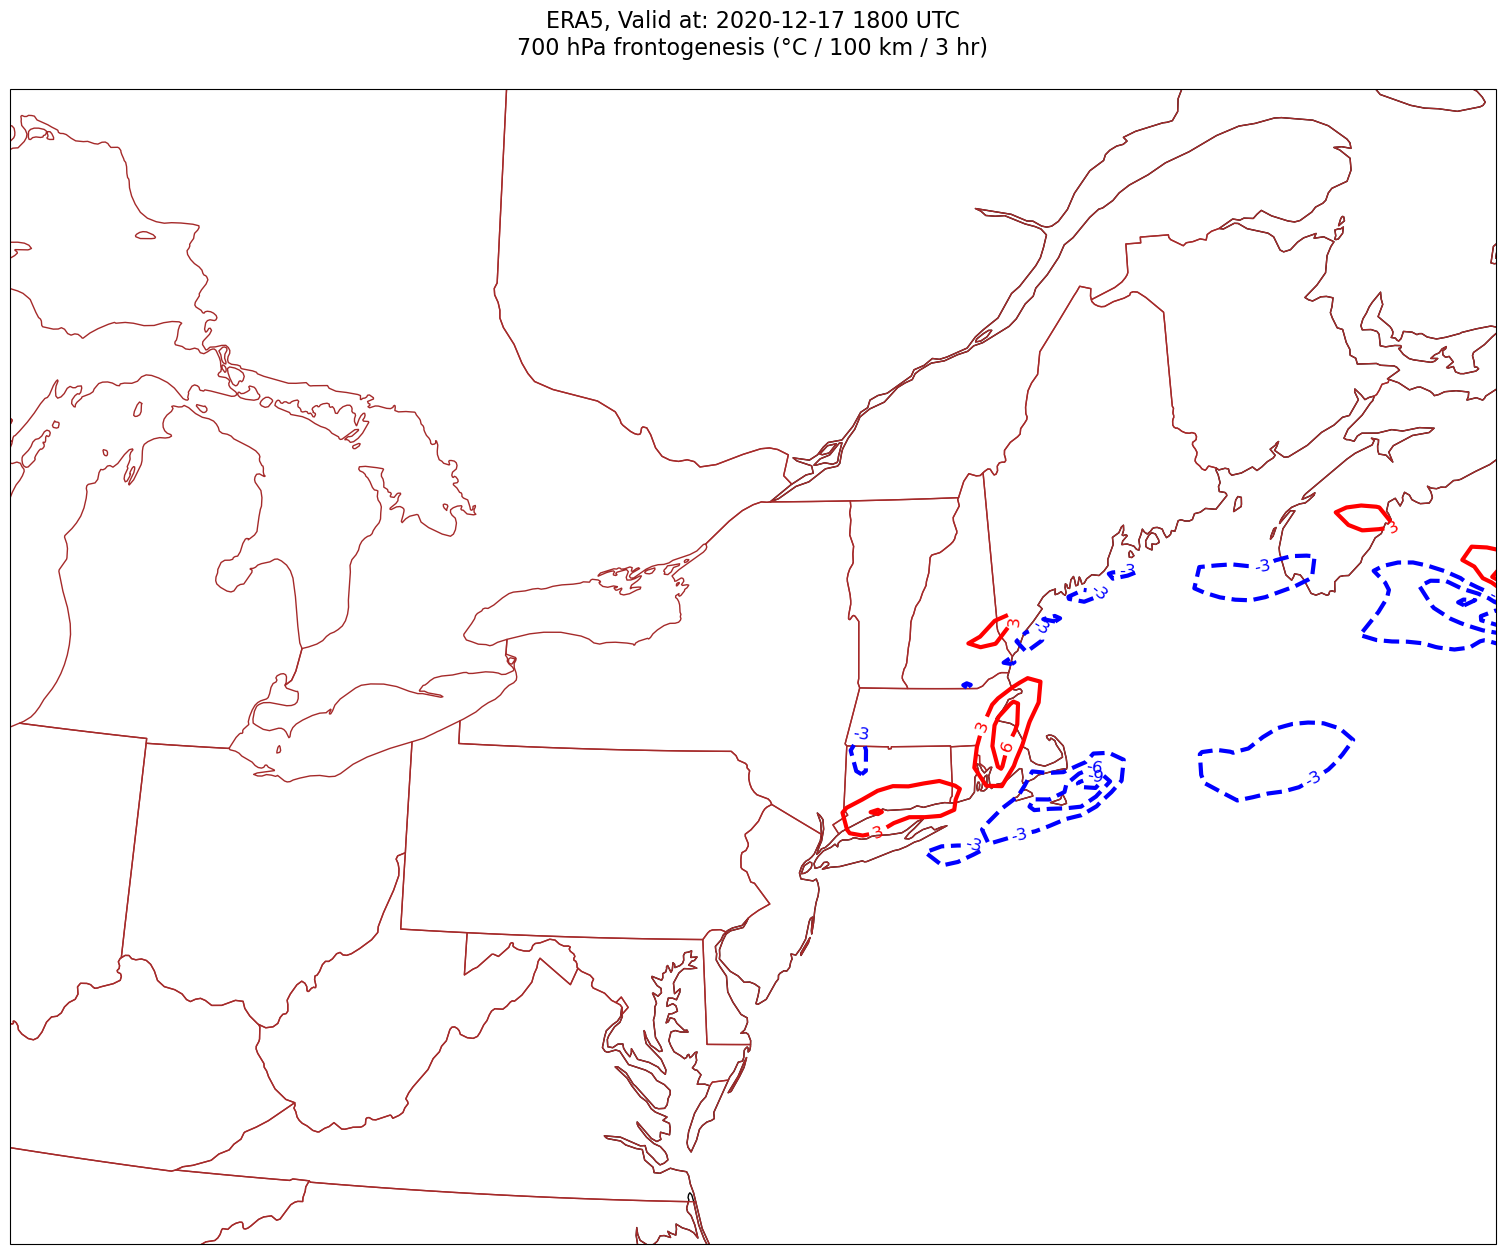

In [19]:
for time in dateList:
    print("Processing", time)
    
    # Create the time strings, for the figure title as well as for the file name.
    timeStr = dt.strftime(time,format="%Y-%m-%d %H%M UTC")
    timeStrFile = dt.strftime(time,format="%Y%m%d%H")
    
    tl1 = f'ERA5, Valid at: {timeStr}'
    tl2 = f'{levStr} hPa frontogenesis (°C / 100 km / 3 hr)'
    
    title_line = f'{tl1}\n{tl2}\n'
    
    fig = plt.figure(figsize=(21,15)) # Increase size to adjust for the constrained lats/lons
    ax = fig.add_subplot(1,1,1,projection=proj_map)
    ax.set_extent ([lonW+constrainLon,lonE-constrainLon,latS+constrainLat,latN-constrainLat])
    ax.add_feature(cfeature.COASTLINE.with_scale(res))
    ax.add_feature(cfeature.STATES.with_scale(res),edgecolor='brown')
    
    # Need to use Xarray's sel method here to specify the current time for any DataArray you are plotting.
    
    # 1a. Contour lines of warm (positive temperature) advection.
    # Don't forget to multiply by the scaling factor!
    cPosTAdv = ax.contour(lons, lats, frnt.sel(time=time)*scale, levels=posFrntContours, colors='red', linewidths=3, transform=proj_data)
    ax.clabel(cPosTAdv, inline=1, fontsize=12, fmt='%.0f')
    
    # 1b. Contour lines of cold (negative temperature) advection
    cNegTAdv = ax.contour(lons, lats, frnt.sel(time=time)*scale, levels=negFrntContours, colors='blue', linewidths=3, transform=proj_data)
    ax.clabel(cNegTAdv, inline=1, fontsize=12, fmt='%.0f')
    
    title = ax.set_title(title_line,fontsize=16)
    #Generate a string for the file name and save the graphic to your current directory.
    fileName = f'{timeStrFile}_ERA5_{levStr}_Frnt.png'
    fig.savefig(fileName)


# <span style="color:purple">4. Smooth the diagnostic field.</span>

Use [MetPy's implementation of a Gaussian smoother](https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.smooth_gaussian.html).

In [20]:
sigma = 7.0 # this depends on how noisy your data is, adjust as necessary
frntSmth = mpcalc.smooth_gaussian(frnt, sigma)

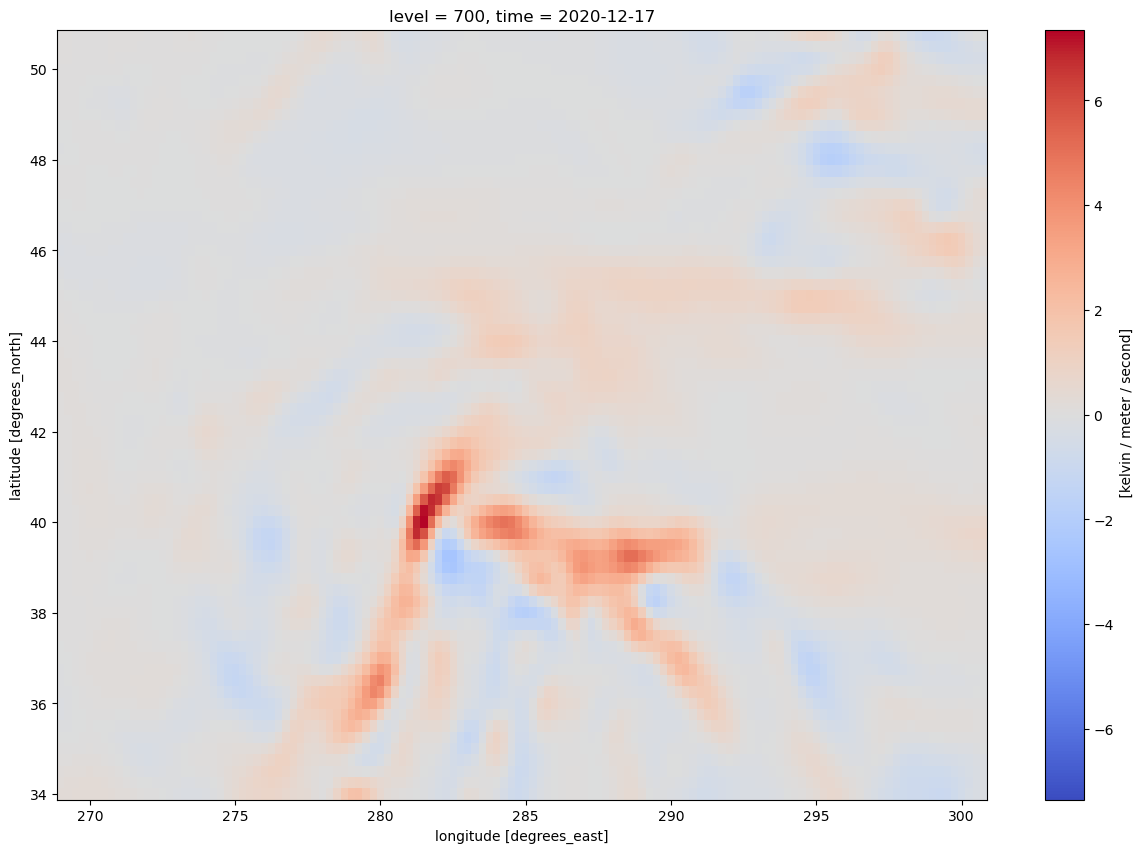

In [21]:
frntSmth.isel(time=0).plot(figsize=(15,10),cmap='coolwarm')

Plot the smoothed field.

Processing 2020-12-17 00:00:00
Processing 2020-12-17 06:00:00
Processing 2020-12-17 12:00:00
Processing 2020-12-17 18:00:00


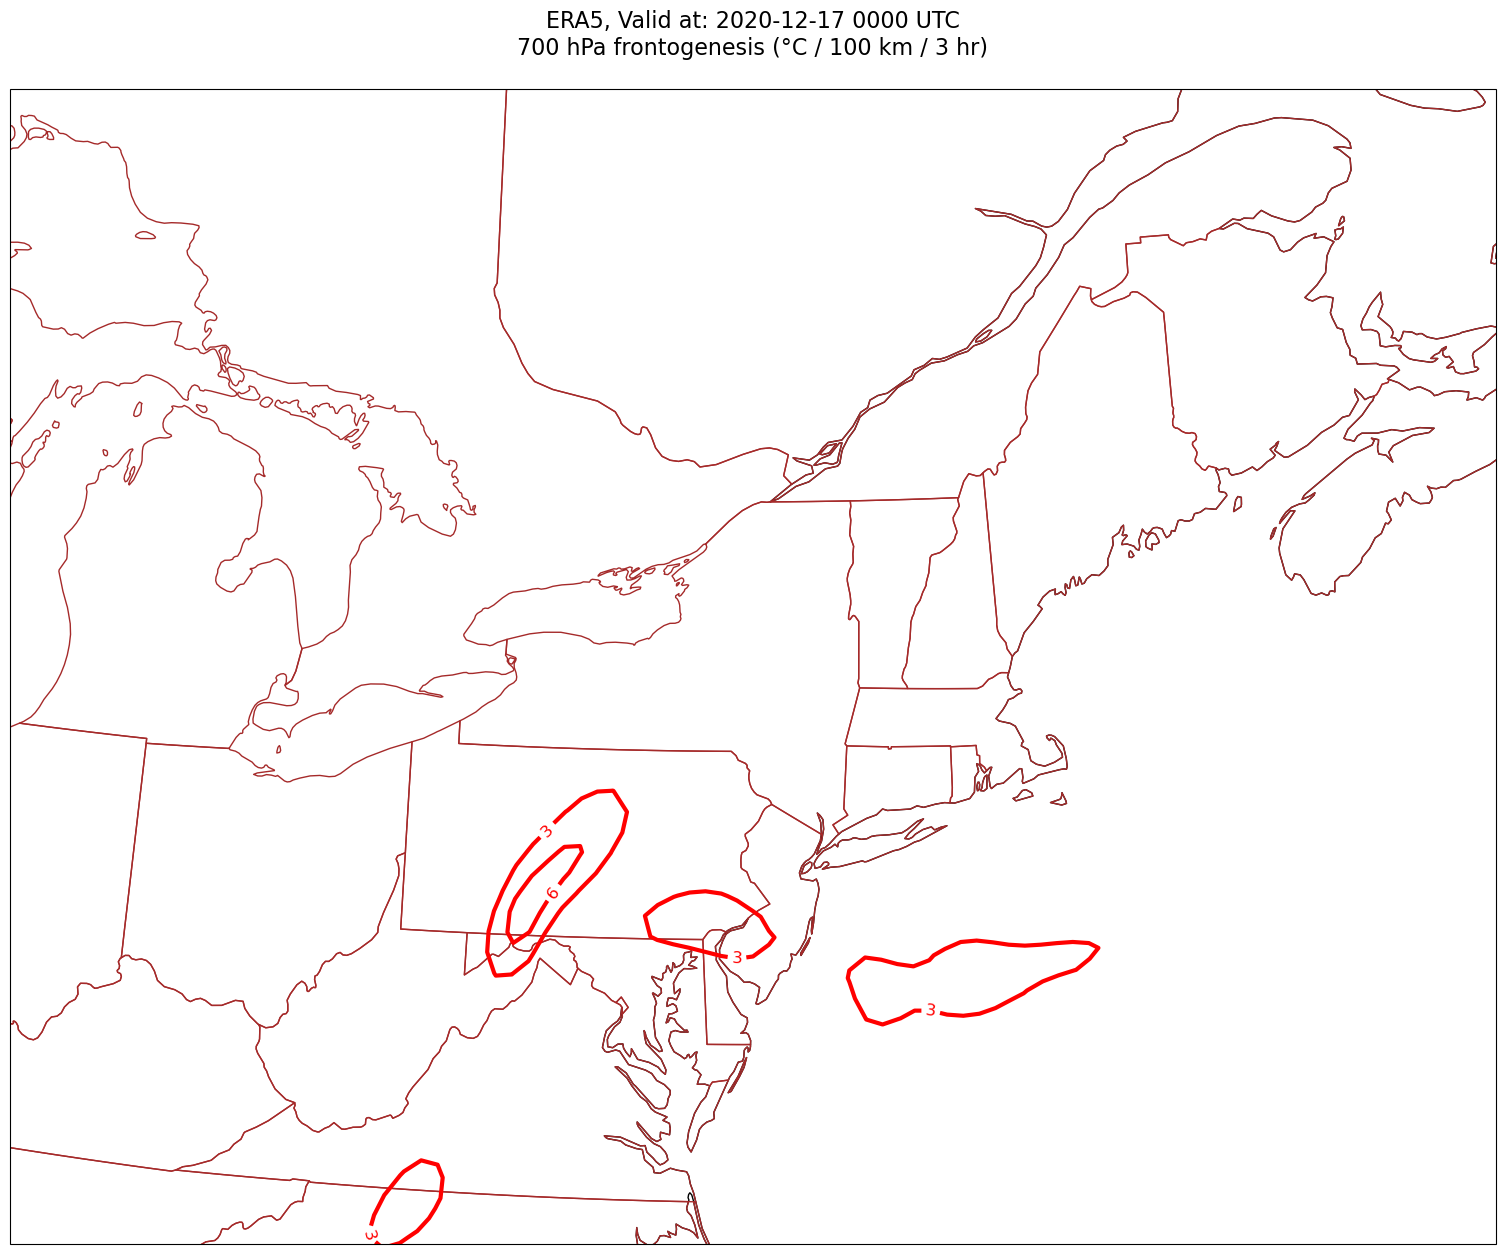

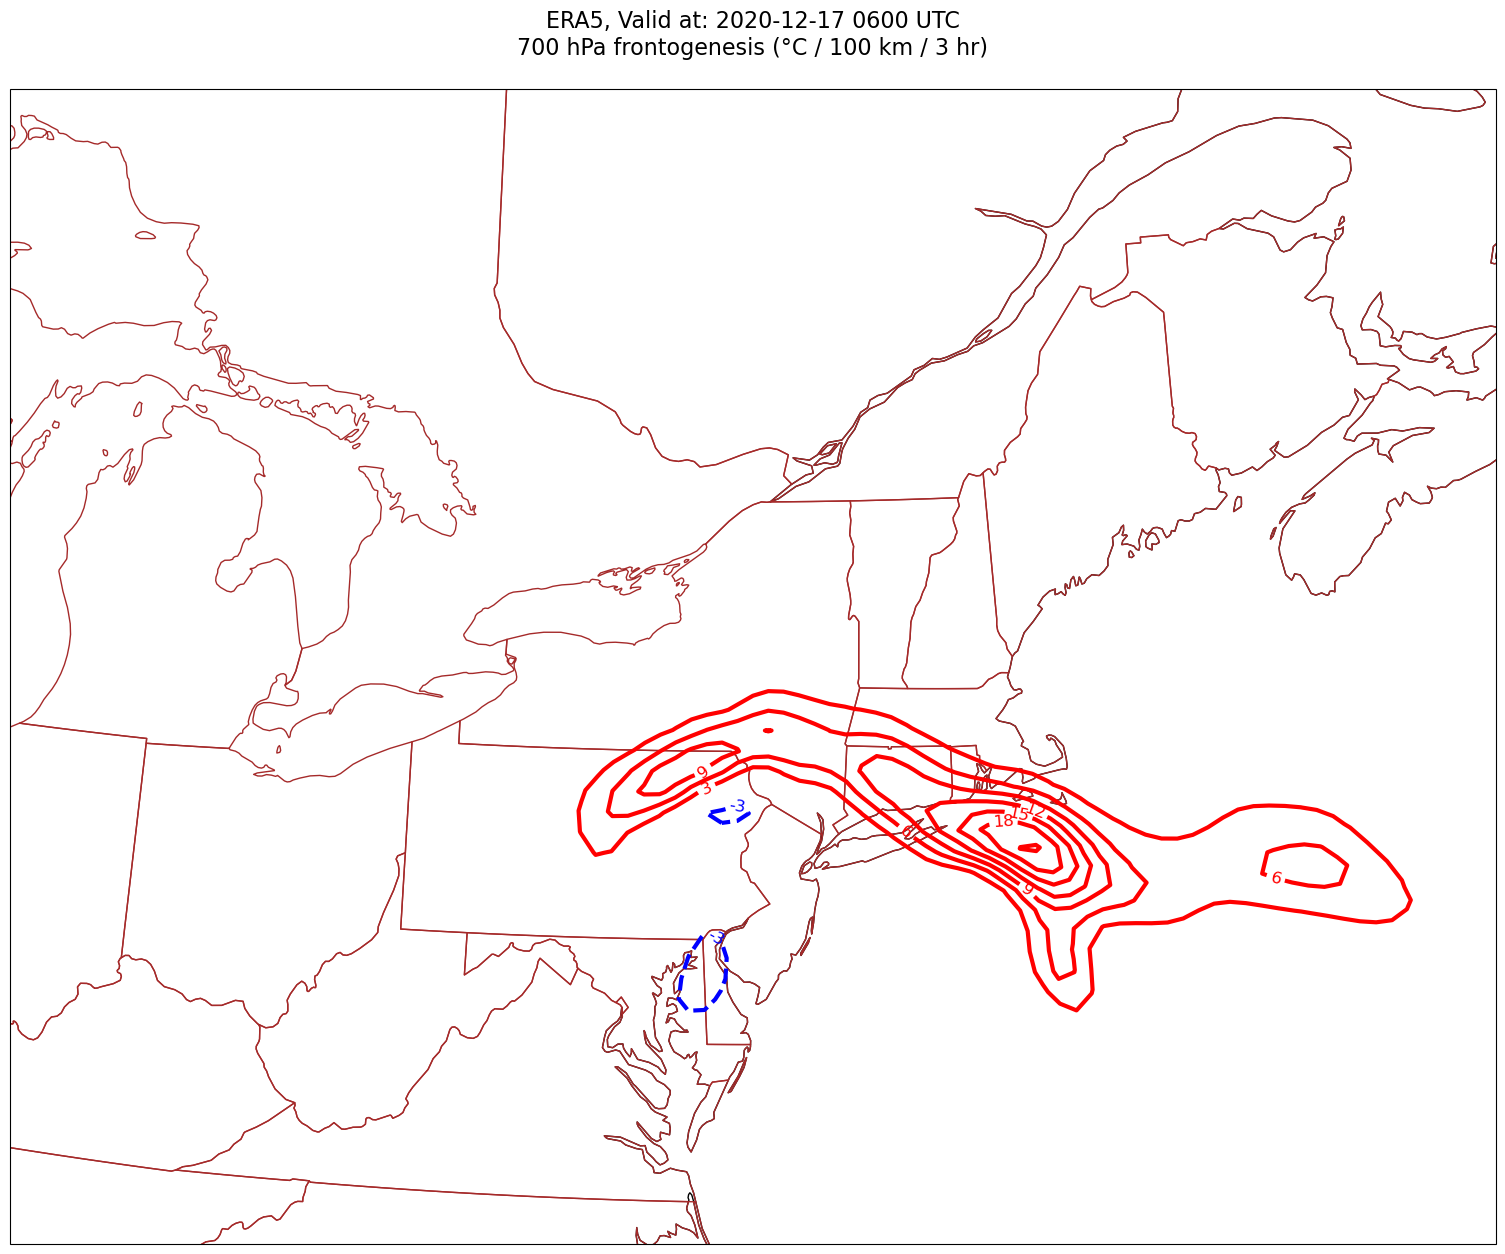

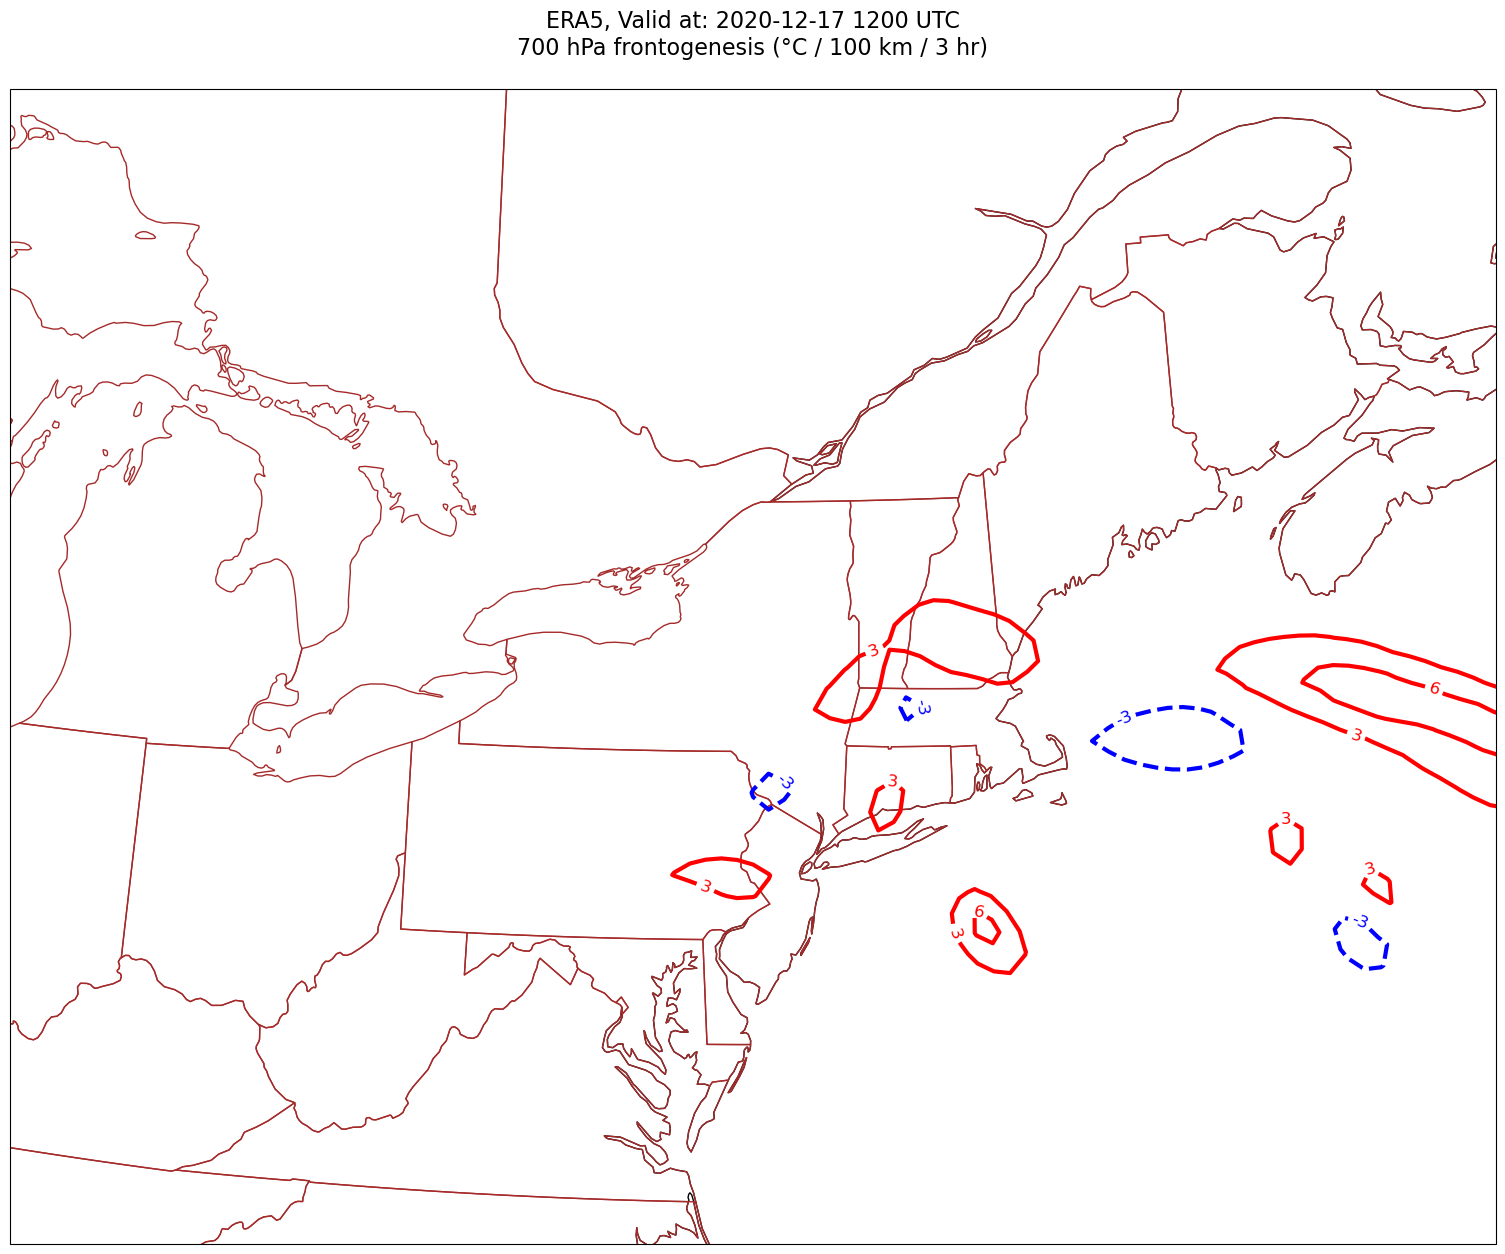

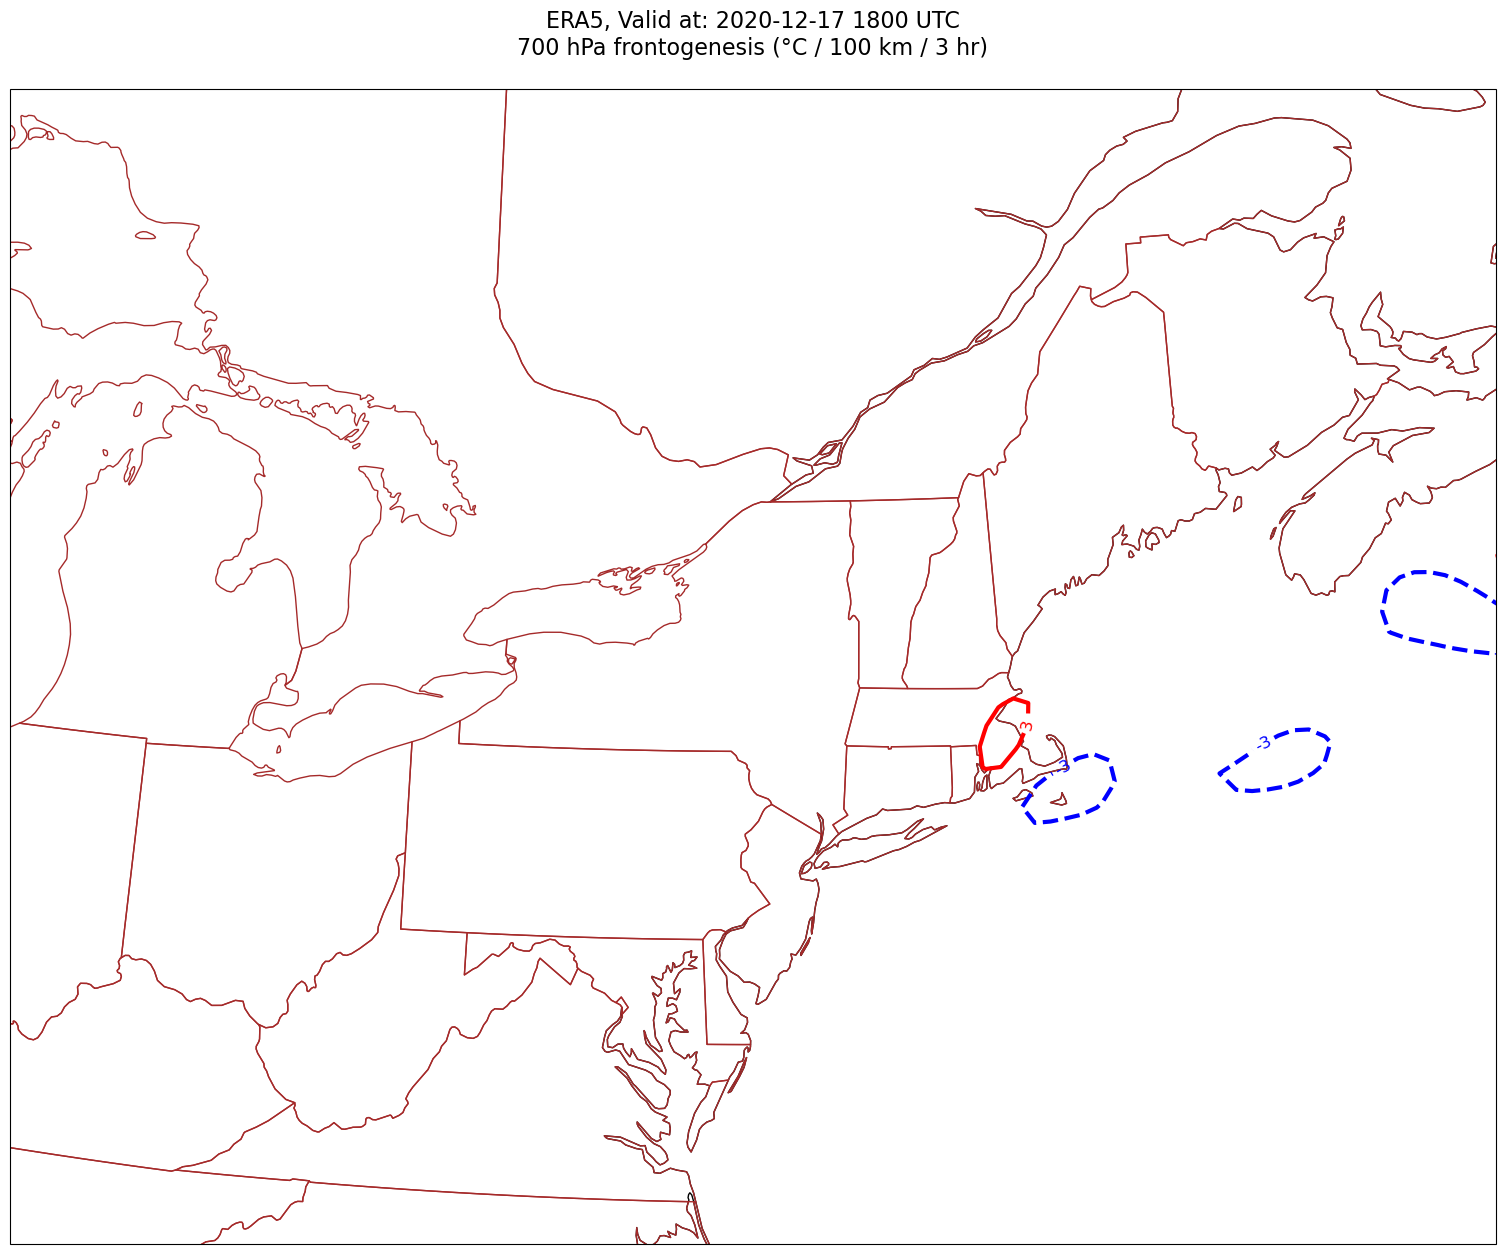

In [22]:
for time in dateList:
    print(f'Processing {time}')
    
    # Create the time strings, for the figure title as well as for the file name.
    timeStr = dt.strftime(time,format="%Y-%m-%d %H%M UTC")
    timeStrFile = dt.strftime(time,format="%Y%m%d%H")
    
    tl1 = f'ERA5, Valid at: {timeStr}'
    tl2 = f'{levStr} hPa frontogenesis (°C / 100 km / 3 hr)'
    title_line = f'{tl1}\n{tl2}\n'    
    
    fig = plt.figure(figsize=(21,15)) # Increase size to adjust for the constrained lats/lons
    ax = fig.add_subplot(1,1,1,projection=proj_map)
    ax.set_extent ([lonW+constrainLon,lonE-constrainLon,latS+constrainLat,latN-constrainLat])
    ax.add_feature(cfeature.COASTLINE.with_scale(res))
    ax.add_feature(cfeature.STATES.with_scale(res),edgecolor='brown')
    
    # Need to use Xarray's sel method here to specify the current time for any DataArray you are plotting.
    
    # 1a. Contour lines of warm (positive temperature) advection.
    # Don't forget to multiply by the scaling factor!
    cPosTAdv = ax.contour(lons, lats, frntSmth.sel(time=time)*scale, levels=posFrntContours, colors='red', linewidths=3, transform=proj_data)
    ax.clabel(cPosTAdv, inline=1, fontsize=12, fmt='%.0f')
    
    # 1b. Contour lines of cold (negative temperature) advection
    cNegTAdv = ax.contour(lons, lats, frntSmth.sel(time=time)*scale, levels=negFrntContours, colors='blue', linewidths=3, transform=proj_data)
    ax.clabel(cNegTAdv, inline=1, fontsize=12, fmt='%.0f')
    
    title = ax.set_title(title_line,fontsize=16)
    #Generate a string for the file name and save the graphic to your current directory.
    fileName = f'{timeStrFile}_ERA5_{levStr}_Frnt.png'
    fig.savefig(fileName)
